In [351]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as ssp
import scipy.linalg as salg
from scipy.sparse.linalg import spsolve, splu
from collections.abc import Callable


In [352]:
#Defining the constants
P = 2		#Power of two
N = 2**P	#Number of subdivisions
U0 = 0.01 	#The border constant we might need to use?
h = 1/N		#Discretisation step

DEBUG = True

In [353]:

def get_elem_mat(N: int, dimension: str) -> ssp.csr_matrix:
	"""Creates the element matrix 'Ah' for the 2D or 3D discrete laplaciaan

	Parameters
	----------
	N : int
	    Number of points in a direction of the grid
	dimension : str
	    2D/3D for two/three-dimensional discrete laplacian

	Returns
	-------
	ssp.csc_matrix
	    The element matrix Ah
	"""	
	one_dim_diff = 2*np.eye((N))-np.eye((N), k=-1)-np.eye((N), k=1)


	ONE_DIM_DIFF	= ssp.csr_matrix(one_dim_diff.astype(int))
	ID 		= ssp.csr_matrix(np.eye(N).astype(int))

	x_dim_diff = (1/(h**2) * ssp.kron(ONE_DIM_DIFF,ID))
	y_dim_diff = (1/(h**2) * ssp.kron(ID, ONE_DIM_DIFF))

	X_DIM_DIFF 	= ssp.csr_matrix(x_dim_diff.astype(int))
	Y_DIM_DIFF 	= ssp.csr_matrix(y_dim_diff.astype(int))
	TWO_LAPLACE 	= ssp.csr_matrix(x_dim_diff + y_dim_diff)

	one_dim_diff = None
	x_dim_diff = None
	y_dim_diff = None

	if dimension == "2D":
		return TWO_LAPLACE

	elif dimension == "3D":	
		z_dim_diff = (1/(h**2)*(
			ssp.kron(ID,
				ssp.kron(ID, ONE_DIM_DIFF)
				)
			)
		)

		Z_DIM_DIFF 	= ssp.csr_matrix(z_dim_diff.astype(int))
		z_dim_diff = None

		THREE_LAPLACE = (ssp.kron(X_DIM_DIFF, ID) 
				+ssp.kron(Y_DIM_DIFF, ID)
				+Z_DIM_DIFF)
		
		return THREE_LAPLACE

	else:
		raise ValueError('string: Dimension, either "2D" or "3D"')


In [354]:
def build_forcing_vector(lin_spaces: list,
			 internal_fun,
			 boundary_fun  = None
			 ) -> np.ndarray:
	"""Builds the RHS of the linear system for a arbitray-dimensional laplacian

	Parameters
	----------
	lin_spaces : list
	    List of arrays of points that will be used to build the meshgrid
	internal_fun : Callable[list[float]]
	    Function that takes n-dimensional coordinate arrays and returns the value of the forcing at that coordinate
	boundary_fun : Callable[list[float]]
	    Function that takes n-dimensional coordinate arrays and returns the value of the forcing at that boundary coordinate

	Returns
	-------
	np.ndarray
	    The forcing vector
	"""	
	grids = np.meshgrid(*lin_spaces)
	internal_forcing_array = internal_fun(*grids)
	if boundary_fun == None:
		def boundary_fun(*grids):
			return 0*grids[0]
			
	boundary_forcing_array = boundary_fun(*grids)

	dims = len(lin_spaces)
	mask = tuple([slice(1,-1)]*dims)
	forcing, forcing[mask] = boundary_forcing_array, internal_forcing_array[mask]
	print(mask)

	forcing_vector = forcing.flatten()
	return forcing_vector


In [355]:
def int_forc_fun(x,y):
	return (x**2 + y**2)*np.sin(x*y)

def bound_forc_fun(x,y):
	return np.sin(x*y)

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

X, Y = np.meshgrid(x,y)

In [356]:
vecF = build_forcing_vector([x,y], int_forc_fun, bound_forc_fun)

(slice(1, -1, None), slice(1, -1, None))


In [357]:
TWO_LAPLACE = get_elem_mat(N+1, "2D")

In [358]:
#Manipulating the 2D-laplacian and the forcing vector to obey boundary elements
#By selecting the boundary points
Xval, Yval = X.ravel(), Y.ravel()

boundary_list = np.squeeze(
	np.where(
		(Xval==x[0]) | (Xval==x[-1]) | (Yval==y[0]) | (Yval==y[-1])
	)
);

SPARSE_ID = ssp.eye((N+1)**2).tocsr()
for row in boundary_list:
	TWO_LAPLACE[row,:] = SPARSE_ID[row,:]
SPARSE_ID = None



In [359]:

# %time test = TWO_LAPLACE.toarray()
# plt.imshow(test)
# plt.colorbar()

In [360]:
boundary_list

array([ 0,  1,  2,  3,  4,  5,  9, 10, 14, 15, 19, 20, 21, 22, 23, 24],
      dtype=int64)

In [361]:
# test[:,boundary_list] = 0*np.ones(((N+1)**2,(N+1)**2))[:,boundary_list]
# plt.imshow(test)
# plt.colorbar()

In [362]:
size = (N+1)**2

TWO_LAPLACE = TWO_LAPLACE.tocsc()
P_MATRIX = ssp.csc_matrix((size,size))


TWO_LAPLACE.shape


(25, 25)

In [363]:
ONES = ssp.csr_matrix((size,size))
ONES[boundary_list,boundary_list] = 1


C:\Users\Jeroe\Python\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [364]:
ZEROES = ssp.csc_matrix((size,size))

for column in boundary_list:
	P_MATRIX[:, column] = TWO_LAPLACE[:, column]
	TWO_LAPLACE[:,column] = ZEROES[:,column]

print(type(TWO_LAPLACE))

TWO_LAPLACE = (TWO_LAPLACE + ONES)
P_MATRIX = (P_MATRIX - ONES)

print(type(TWO_LAPLACE))

<class 'scipy.sparse.csc.csc_matrix'>
<class 'scipy.sparse.csc.csc_matrix'>


C:\Users\Jeroe\Python\lib\site-packages\scipy\sparse\_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [365]:
pm = P_MATRIX

In [366]:
P_MATRIX.shape

(25, 25)

In [367]:
#Building u0
U0 = np.sin(X*Y)
u0 = U0.flatten()
to_subtract = P_MATRIX.dot(u0)


In [368]:
vecF = np.subtract(vecF, to_subtract)

In [369]:
TWO_LAPLACE.shape

(25, 25)

In [370]:
u = spsolve(TWO_LAPLACE, vecF.T)

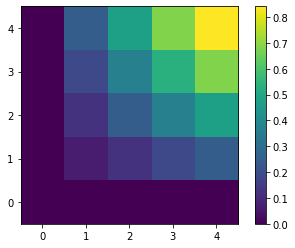

In [371]:
array_u = u.reshape((N+1,N+1))
plt.imshow(array_u, origin='lower');
plt.colorbar()

In [372]:
u_ex = np.sin(X*Y)
vec_u_ex = u_ex.flatten()

In [373]:
error = np.sqrt(h**2 *np.sum((vec_u_ex-u)**2))
print("h**2: {:.5f}\t error: {:.5f}".format(h**2, error))
print('relative error: {:.4f}\t [h**2]'.format(error/(h**2)))

h**2: 0.06250	 error: 0.00002
relative error: 0.0003	 [h**2]


C:\Users\Jeroe\Python\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


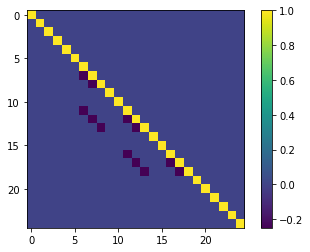

In [374]:
matrix_shape = TWO_LAPLACE.shape
ID = ssp.eye(matrix_shape[0])

SUM = ID.copy()
for k in range(0, matrix_shape[1]):
	Akk = TWO_LAPLACE[k,k]
	VEC = TWO_LAPLACE[:,k] / Akk
	VEC[0:k+1] = ZEROES[0:k+1,0] 

	EK = ZEROES[:,0].copy()
	EK[k] = 1

	ADD = VEC * EK.T

	SUM += ADD

L = SUM

plt.imshow(L.toarray())
plt.colorbar()


In [375]:
def decomp_lu(M: ssp.csc_matrix) -> ssp.csc_matrix:
	"""Creates the sparse lower matrix of the LU decomposition of M

	Parameters
	----------
	M : ssp.csc_matrix
	    The matrix to LU decompose such that L@U = M

	Returns
	-------
	ssp.csc_matrix
	    The sparse lower matrix L
	"""
	#In this code block all fully uppercase variables are sparse matrices
	shape_m = M.shape
	ID = ssp.eye(shape_m[0])
	ZEROES = ssp.csc_matrix(shape_m)

	SUM = ID.copy()
	for k in range(0, shape_m[1]):
		Akk = M[k,k]
		VEC = M[:,k] / Akk
		VEC[0: k+1] = ZEROES[0:k+1, 0]

		EK = ZEROES[:,0].copy()
		EK[k] = 1

		ADD = VEC * EK.T
		SUM += ADD
		
	return SUM

In [376]:
def decomp_cholesky(M: ssp.csc_matrix) -> ssp.csc_matrix:
	shape_m = M.shape
	C = ssp.csc_matrix(shape_m)
	TMP = M.copy()

	for k in range(0, shape_m[0]):
		C[k,k] = np.sqrt(( M[k,k] - (C[k, 0:k].power(2)).sum()))
		TMP[k,k] = C[k,k]

		for i in range(k+1, shape_m[1]):
			C[i,k] = 1/C[k,k] * (M[i,k] - (C[i,0:k].multiply(C[k,0:k]).sum()))
			TMP[i,k] = C[i,k]

	return C


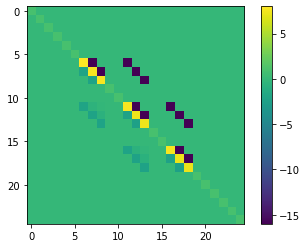

In [382]:
plt.imshow(TWO_LAPLACE.toarray())
plt.colorbar()

In [377]:
C = decomp_cholesky(TWO_LAPLACE)

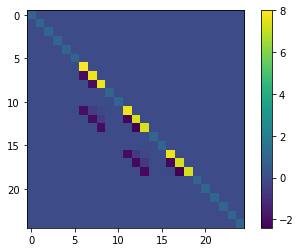

In [378]:
plt.imshow(C.toarray())
plt.colorbar()

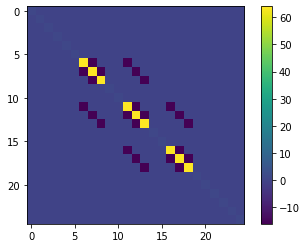

In [379]:
ORIGINAL_MAYBE = C@C.T

plt.imshow(ORIGINAL_MAYBE.toarray())
plt.colorbar()

In [380]:
LL = decomp_lu(TWO_LAPLACE)

np.alltrue(LL.toarray() == L.toarray())

False

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csc.csc_matrix'>


C:\Users\Jeroe\Python\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


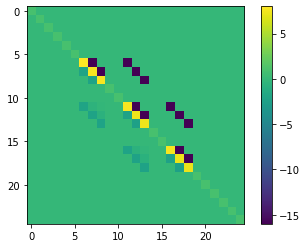

In [381]:
print(type(L), type(TWO_LAPLACE))

U = spsolve(L, TWO_LAPLACE)

plt.imshow((L@U).toarray())
plt.colorbar()